In [1]:
import numpy as np 
import pandas as pd
import re
import gc
import os
import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

ModuleNotFoundError: No module named 'numpy'

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
#valid_forms = ['am','are','were','was','is','been','being','be']
#blank = '----'

In [ ]:
def detect(tokens):
    return [t for t in tokens if t in valid_forms]
    
def replace_blank(tokens):
    return [blank if t in valid_forms else t for t in tokens]

def create_windows(tokens, window_size=3):
    X = []
    for i, word in enumerate(tokens):
        if word == blank:
            window = tokens[i-window_size:i] + tokens[i+1:i+window_size+1]
            window = ' '.join(window)
            X.append(window)    
    return X

In [ ]:

#print(os.listdir("../input"))


In [ ]:
# f1 = open("../input/internet_archive_scifi_v3.txt","r")
# a = f1.read()
# a = re.sub('[\n]', '', a)
# tokens = wordpunct_tokenize(a)
# y = detect(tokens)
# tokens = replace_blank(tokens)
# X = create_windows(tokens)
# f1.close()
# df = pd.DataFrame()
# df["Text"] = X
# df["Label"] = y
# one_hot = pd.get_dummies(df["Label"])
# df.drop(['Label'],axis=1,inplace=True)
# df = pd.concat([df,one_hot],axis=1)
# df.head()
# df1 = df[:200000]
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df1["Text"].values, df1.drop(['Text'],axis=1).values, test_size=0.2, random_state=42)

In [ ]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
#df.head()

In [ ]:
df = pd.read_csv('whole_mal.tsv',sep='\t',names=['category','text'])
print(df.shape)

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

(6739, 2)


In [ ]:




# y=df['category']
# #y = pd.get_dummies(df['category']).values

# X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2)

# y = np_utils.to_categorical(df.category.factorize()[0])

# X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=33, test_size=0.2)

In [ ]:
y=df['category']
#y = pd.get_dummies(df['category']).values

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train=pd.get_dummies(y_train).values
y_test=pd.get_dummies(y_test).values
diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'unknown state ',
 1: 'not-malayalam ',
 2: 'Positive ',
 3: 'Negative ',
 4: 'Mixed feelings '}

In [ ]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=50)

In [ ]:
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=50)

In [ ]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
class_weights

array([3.23783784, 1.797     , 0.48005343, 1.52503536, 0.71641196])

In [ ]:
# model.fit(X_train, y_train,
#                     batch_size=1024,
#                     epochs=10,
#                     verbose=1,
#                     validation_split=0.1,class_weight=class_weights)

Train on 4851 samples, validate on 540 samples
Epoch 1/10
4851/4851 [==============================] - 0s 85us/step - loss: 0.6900 - acc: 0.7720 - val_loss: 1.0054 - val_acc: 0.6259
Epoch 2/10
4851/4851 [==============================] - 0s 73us/step - loss: 0.5489 - acc: 0.8256 - val_loss: 1.0069 - val_acc: 0.6352
Epoch 3/10
4851/4851 [==============================] - 0s 71us/step - loss: 0.4356 - acc: 0.8613 - val_loss: 0.9820 - val_acc: 0.6500
Epoch 4/10
4851/4851 [==============================] - 0s 69us/step - loss: 0.3441 - acc: 0.8786 - val_loss: 1.0144 - val_acc: 0.6611
Epoch 5/10
4851/4851 [==============================] - 0s 71us/step - loss: 0.2721 - acc: 0.8932 - val_loss: 1.0438 - val_acc: 0.6778
Epoch 6/10
4851/4851 [==============================] - 0s 73us/step - loss: 0.2170 - acc: 0.9128 - val_loss: 1.0739 - val_acc: 0.6463
Epoch 7/10
4851/4851 [==============================] - 0s 73us/step - loss: 0.1784 - acc: 0.9437 - val_loss: 1.1458 - val_acc: 0.6537
Epoch 8/

In [ ]:
model=load_model('1Dconv-lstm_model.h5')

In [ ]:
score = model.evaluate(X_test, y_test,
                       batch_size=256, verbose=1)
print('Test accuracy:', score[1])

1348/1348 [==============================] - 1s 395us/step
Test accuracy: 0.6335311570931613


In [ ]:
preds = model.predict(X_test)

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

              precision    recall  f1-score   support

           0       0.26      0.26      0.26        70
           1       0.56      0.33      0.41       138
           2       0.70      0.74      0.72       565
           3       0.62      0.75      0.68       177
           4       0.61      0.60      0.61       398

   micro avg       0.63      0.63      0.63      1348
   macro avg       0.55      0.54      0.54      1348
weighted avg       0.63      0.63      0.63      1348



In [ ]:
#model.save('1Dconv-lstm_model.h5') already save good model

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

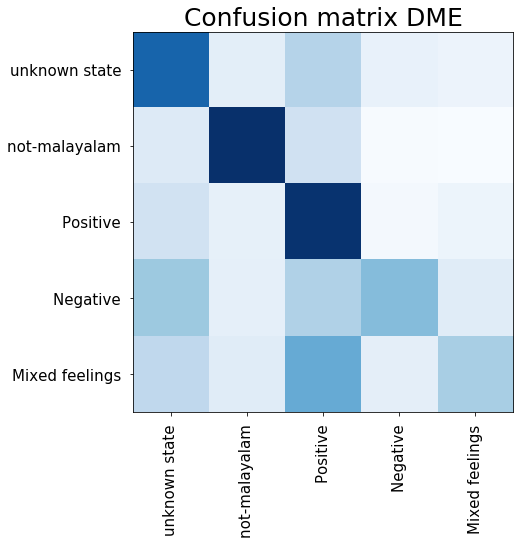

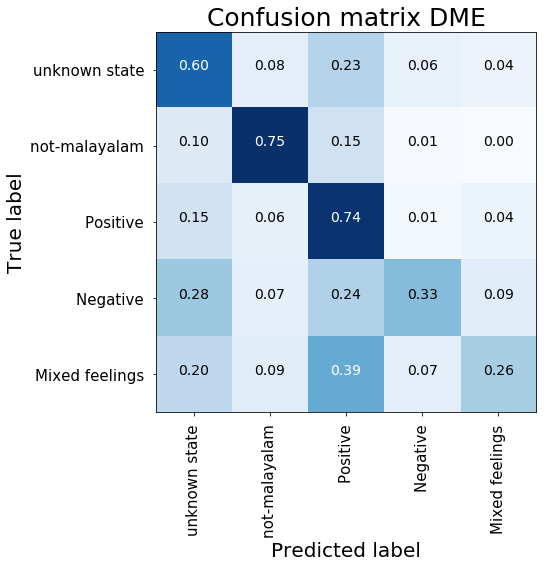

In [ ]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(preds, axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

# BERT implementation

In [ ]:
# !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py 

--2020-01-13 17:54:42--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py.2’

modeling.py.2       100%[===================>]  37.03K  --.-KB/s    in 0.004s  

2020-01-13 17:54:42 (8.51 MB/s) - ‘modeling.py.2’ saved [37922/37922]

--2020-01-13 17:54:42--  https://raw.githubusercontent.com/google-research/bert/master/optimization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6258 (6.1K) [text/plain]
Saving to: ‘optimi

In [ ]:
import modeling
import optimization
import run_classifier
import tokenization

W0113 17:54:46.615442 139929347827456 deprecation_wrapper.py:119] From /home/bharaj/papers/code-mix/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
folder = 'model_folder'
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)

In [ ]:
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: model_folder/outputs
>>  BERT pretrained directory: model_folder/uncased_L-12_H-768_A-12


In [ ]:
df = pd.read_csv('whole_mal.tsv',sep='\t',names=['category','text'])
print(df.shape)

y=df['category']
df2 = pd.DataFrame()
df2["Text"] = df["text"]
df2["Label"] = LabelEncoder().fit_transform(y)
#df2 = df2[:200000]
print(df2.head())
X_train, X_test, y_train, y_test = train_test_split(df2["Text"].values, df2["Label"].values, test_size=0.2, random_state=5)

(6739, 2)
                                                Text  Label
0   Ichayan fans pinne mmade ettan fansm ivde oru...      4
1             Tovi 🥰 Best Wishes From #Kunjikka Fans      3
2   Urutty koll .nallavanaaya unniyaya saiju kuru...      4
3   Pls support me pls       My channel subscribe...      3
4     Kalki super hit akum enn Bonny parayan paranju      2


In [ ]:
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 50
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

label_list = [str(num) for num in range(8)]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

W0113 16:02:01.033734 139885884110592 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f392d5c1840>) includes params argument, but params are not passed to Estimator.
W0113 16:02:01.038019 139885884110592 tpu_context.py:211] eval_on_tpu ignored because use_tpu is False.


In [ ]:
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

Please wait...
>> Started training at 2020-01-13 16:02:16.864424 
  Num examples = 5391
  Batch size = 32
>> Finished training at 2020-01-13 16:02:16.901401


In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    batch_size = 500

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(y_test,preds))
print(classification_report(y_test,preds))

In [ ]:
print("Accuracy of BERT is:",accuracy_score(y_test,preds))

Accuracy of BERT is: 0.7759643916913946


In [ ]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.57      0.55      0.56       138
           2       0.83      0.87      0.85       565
           3       0.87      0.93      0.90       177
           4       0.73      0.79      0.76       398

   micro avg       0.78      0.78      0.78      1348
   macro avg       0.60      0.63      0.61      1348
weighted avg       0.73      0.78      0.75      1348



/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-01-13 16:24:38--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M  8.67MB/s    in 57s     

2020-01-13 16:25:37 (11.1 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [ ]:
folder = 'model_folder'
with zipfile.ZipFile("multi_cased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)
BERT_MODEL = 'multi_cased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/multi_cased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs-n'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: model_folder/outputs-n
>>  BERT pretrained directory: model_folder/multi_cased_L-12_H-768_A-12


In [ ]:
OUTPUT_DIR = f'{folder}/outputs-n'
df = pd.read_csv('whole_mal.tsv',sep='\t',names=['category','text'])
print(df.shape)

y=df['category']
df2 = pd.DataFrame()
df2["Text"] = df["text"]
df2["Label"] = LabelEncoder().fit_transform(y)
#df2 = df2[:200000]
print(df2.head())

X_train, X_test, y_train, y_test = train_test_split(df2["Text"].values, df2["Label"].values, test_size=0.2, random_state=5)
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 50
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('multi_cased')

label_list = [str(num) for num in range(8)]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

W0113 17:55:35.428941 139929347827456 deprecation_wrapper.py:119] From /home/bharaj/papers/code-mix/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



(6739, 2)
                                                Text  Label
0   Ichayan fans pinne mmade ettan fansm ivde oru...      4
1             Tovi 🥰 Best Wishes From #Kunjikka Fans      3
2   Urutty koll .nallavanaaya unniyaya saiju kuru...      4
3   Pls support me pls       My channel subscribe...      3
4     Kalki super hit akum enn Bonny parayan paranju      2


W0113 17:55:36.953854 139929347827456 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0113 17:55:36.956168 139929347827456 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f4341fedb70>) includes params argument, but params are not passed to Estimator.
W0113 17:55:36.958989 139929347827456 tpu_context.py:211] eval_on_tpu ignored because use_tpu is False.
W0113 17:55:36.960574 139929347827456 deprecation_wrapper.py:119] From /home/bharaj/papers/code-mix/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



Please wait...
>> Started training at 2020-01-13 17:55:39.012120 
  Num examples = 5391
  Batch size = 32
>> Finished training at 2020-01-13 17:55:39.023486


In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    batch_size = 500

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}


W0113 17:56:04.112214 139929347827456 deprecation_wrapper.py:119] From /home/bharaj/papers/code-mix/modeling.py:171: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0113 17:56:04.120874 139929347827456 deprecation_wrapper.py:119] From /home/bharaj/papers/code-mix/modeling.py:409: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0113 17:56:04.171317 139929347827456 deprecation_wrapper.py:119] From /home/bharaj/papers/code-mix/modeling.py:490: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.

W0113 17:56:04.459702 139929347827456 deprecation.py:323] From /home/bharaj/papers/code-mix/modeling.py:671: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0113 17:56:07.976605 139929347827456 deprecation_wrapper.py:119] From /home/bharaj/papers/code-mix/run_clas

W0113 17:56:24.884884 139929347827456 error_handling.py:130] Reraising captured error


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[25000,119547] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node bert/embeddings/one_hot (defined at /home/bharaj/papers/code-mix/modeling.py:416) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss/Softmax/_1235]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[25000,119547] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node bert/embeddings/one_hot (defined at /home/bharaj/papers/code-mix/modeling.py:416) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node bert/embeddings/one_hot:
 bert/embeddings/Reshape (defined at /home/bharaj/papers/code-mix/modeling.py:414)

Input Source operations connected to node bert/embeddings/one_hot:
 bert/embeddings/Reshape (defined at /home/bharaj/papers/code-mix/modeling.py:414)

Original stack trace for 'bert/embeddings/one_hot':
  File "/home/bharaj/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bharaj/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-23b907ae34ab>", line 14, in <module>
    for prediction in result:
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/tpu/tpu_estimator.py", line 2913, in predict
    yield_single_examples=yield_single_examples):
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 619, in predict
    features, None, ModeKeys.PREDICT, self.config)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/tpu/tpu_estimator.py", line 2709, in _call_model_fn
    config)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1146, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/tpu/tpu_estimator.py", line 2967, in _model_fn
    features, labels, is_export_mode=is_export_mode)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/tpu/tpu_estimator.py", line 1549, in call_without_tpu
    return self._call_model_fn(features, labels, is_export_mode=is_export_mode)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/tpu/tpu_estimator.py", line 1867, in _call_model_fn
    estimator_spec = self._model_fn(features=features, **kwargs)
  File "/home/bharaj/papers/code-mix/run_classifier.py", line 645, in model_fn
    num_labels, use_one_hot_embeddings)
  File "/home/bharaj/papers/code-mix/run_classifier.py", line 583, in create_model
    use_one_hot_embeddings=use_one_hot_embeddings)
  File "/home/bharaj/papers/code-mix/modeling.py", line 180, in __init__
    use_one_hot_embeddings=use_one_hot_embeddings)
  File "/home/bharaj/papers/code-mix/modeling.py", line 416, in embedding_lookup
    one_hot_input_ids = tf.one_hot(flat_input_ids, depth=vocab_size)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 3027, in one_hot
    name)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5731, in one_hot
    off_value=off_value, axis=axis, name=name)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(y_test,preds))
print(classification_report(y_test,preds))

ValueError: Found input variables with inconsistent numbers of samples: [1348, 0]